# Design and Implementation of a Machine Learning-based Intrusion Detection System using KNN, SVM and Random Forest to Classify Network Traffic as Normal or Abnormal  

**Dataset Source:** [Kaggle - KDD99 IDS Dataset](https://www.kaggle.com/datasets/sampadab17/network-intrusion-detection)

# Initial Setups

1. **Create a virtual environment**

```bash
%> python -m venv venv
```
---

2. **Activate the virtual environment**
    - For MacOs/Linux users (terminal)
        ```bash
        %> source venv/bin/activate
        ```


    - For windows users (command prompt)
        ```bash
        %> ./venv/Scripts/activate.bat
        ```

    - For windows users (Powershell)
      ```bash
      %> ./venv/Scripts/activate.ps1
      ```
---

3. **Install dependencies**
    - uv
      ```bash
      %> uv add -r requirements.txt
      ```

    - pip
      ```bash
      %> pip install -r requirements.txt
      ```

## Imports & Configs

In [1]:
# %pip install -r requirements.txt

In [2]:
import itertools
import joblib
import os
import warnings

# Data Analysis
import numpy as np
import pandas as pd

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt

# Data Preprocessing
from tabulate import tabulate
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE

# ML Models
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

# Parameter-tunning (optimization)
import optuna

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Data Preprocessing & EDA

In [3]:
train=pd.read_csv('Datasets/Train_data.csv')
test=pd.read_csv('Datasets/Test_data.csv')

In [4]:
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,tcp,exec,RSTO,0,0,0,0,0,0,...,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25188,0,tcp,ftp_data,SF,334,0,0,0,0,0,...,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,anomaly
25189,0,tcp,private,REJ,0,0,0,0,0,0,...,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25190,0,tcp,nnsp,S0,0,0,0,0,0,0,...,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [5]:
print(f"Training set Shape: {train.shape}")
print(f"Testing set Shape: {test.shape}")

Training set Shape: (25192, 42)
Testing set Shape: (22544, 41)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [7]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [8]:
# Numerical data summary
train.describe().round(2)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.00,2.519200e+04,25192.00,25192.00,25192.00,25192.00,25192.00,25192.00,25192.00,25192.00,...,25192.00,25192.00,25192.00,25192.00,25192.00,25192.00,25192.00,25192.00,25192.00,25192.00
mean,305.05,2.433063e+04,3491.85,0.00,0.02,0.00,0.20,0.00,0.39,0.23,...,182.53,115.06,0.52,0.08,0.15,0.03,0.29,0.28,0.12,0.12
std,2686.56,2.410805e+06,88830.72,0.01,0.26,0.01,2.15,0.05,0.49,10.42,...,98.99,110.65,0.45,0.19,0.31,0.11,0.45,0.45,0.31,0.32
min,0.00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,84.00,10.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,4.400000e+01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,255.00,61.00,0.51,0.03,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,2.790000e+02,530.25,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,255.00,255.00,1.00,0.07,0.06,0.02,1.00,1.00,0.00,0.00
max,42862.00,3.817091e+08,5151385.00,1.00,3.00,1.00,77.00,4.00,1.00,884.00,...,255.00,255.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [9]:
# Categorical data summary
train.describe(include='object')

,protocol_type,service,flag,class
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,normal
freq,20526,8003,14973,13449


## Missing Data

In [10]:
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")
else:
    print("No missing values")

No missing values


## Duplicates 

In [11]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


Great! No duplicates

## Outliers 

In [12]:
# def show_outliers(df):
#     for col in df.columns:
#         if col != 'class' and is_numeric_dtype(df[col]) and df[col].nunique() > 10:
#             fig, ax = plt.subplots(2, 1, figsize=(12, 8))
#             g1 = sns.boxplot(x = df[col], ax=ax[0])
#             g2 = sns.scatterplot(data=df, x=df[col],y=df['class'], ax=ax[1])
#             plt.show()

# show_outliers(train)

No outliers

<Axes: >

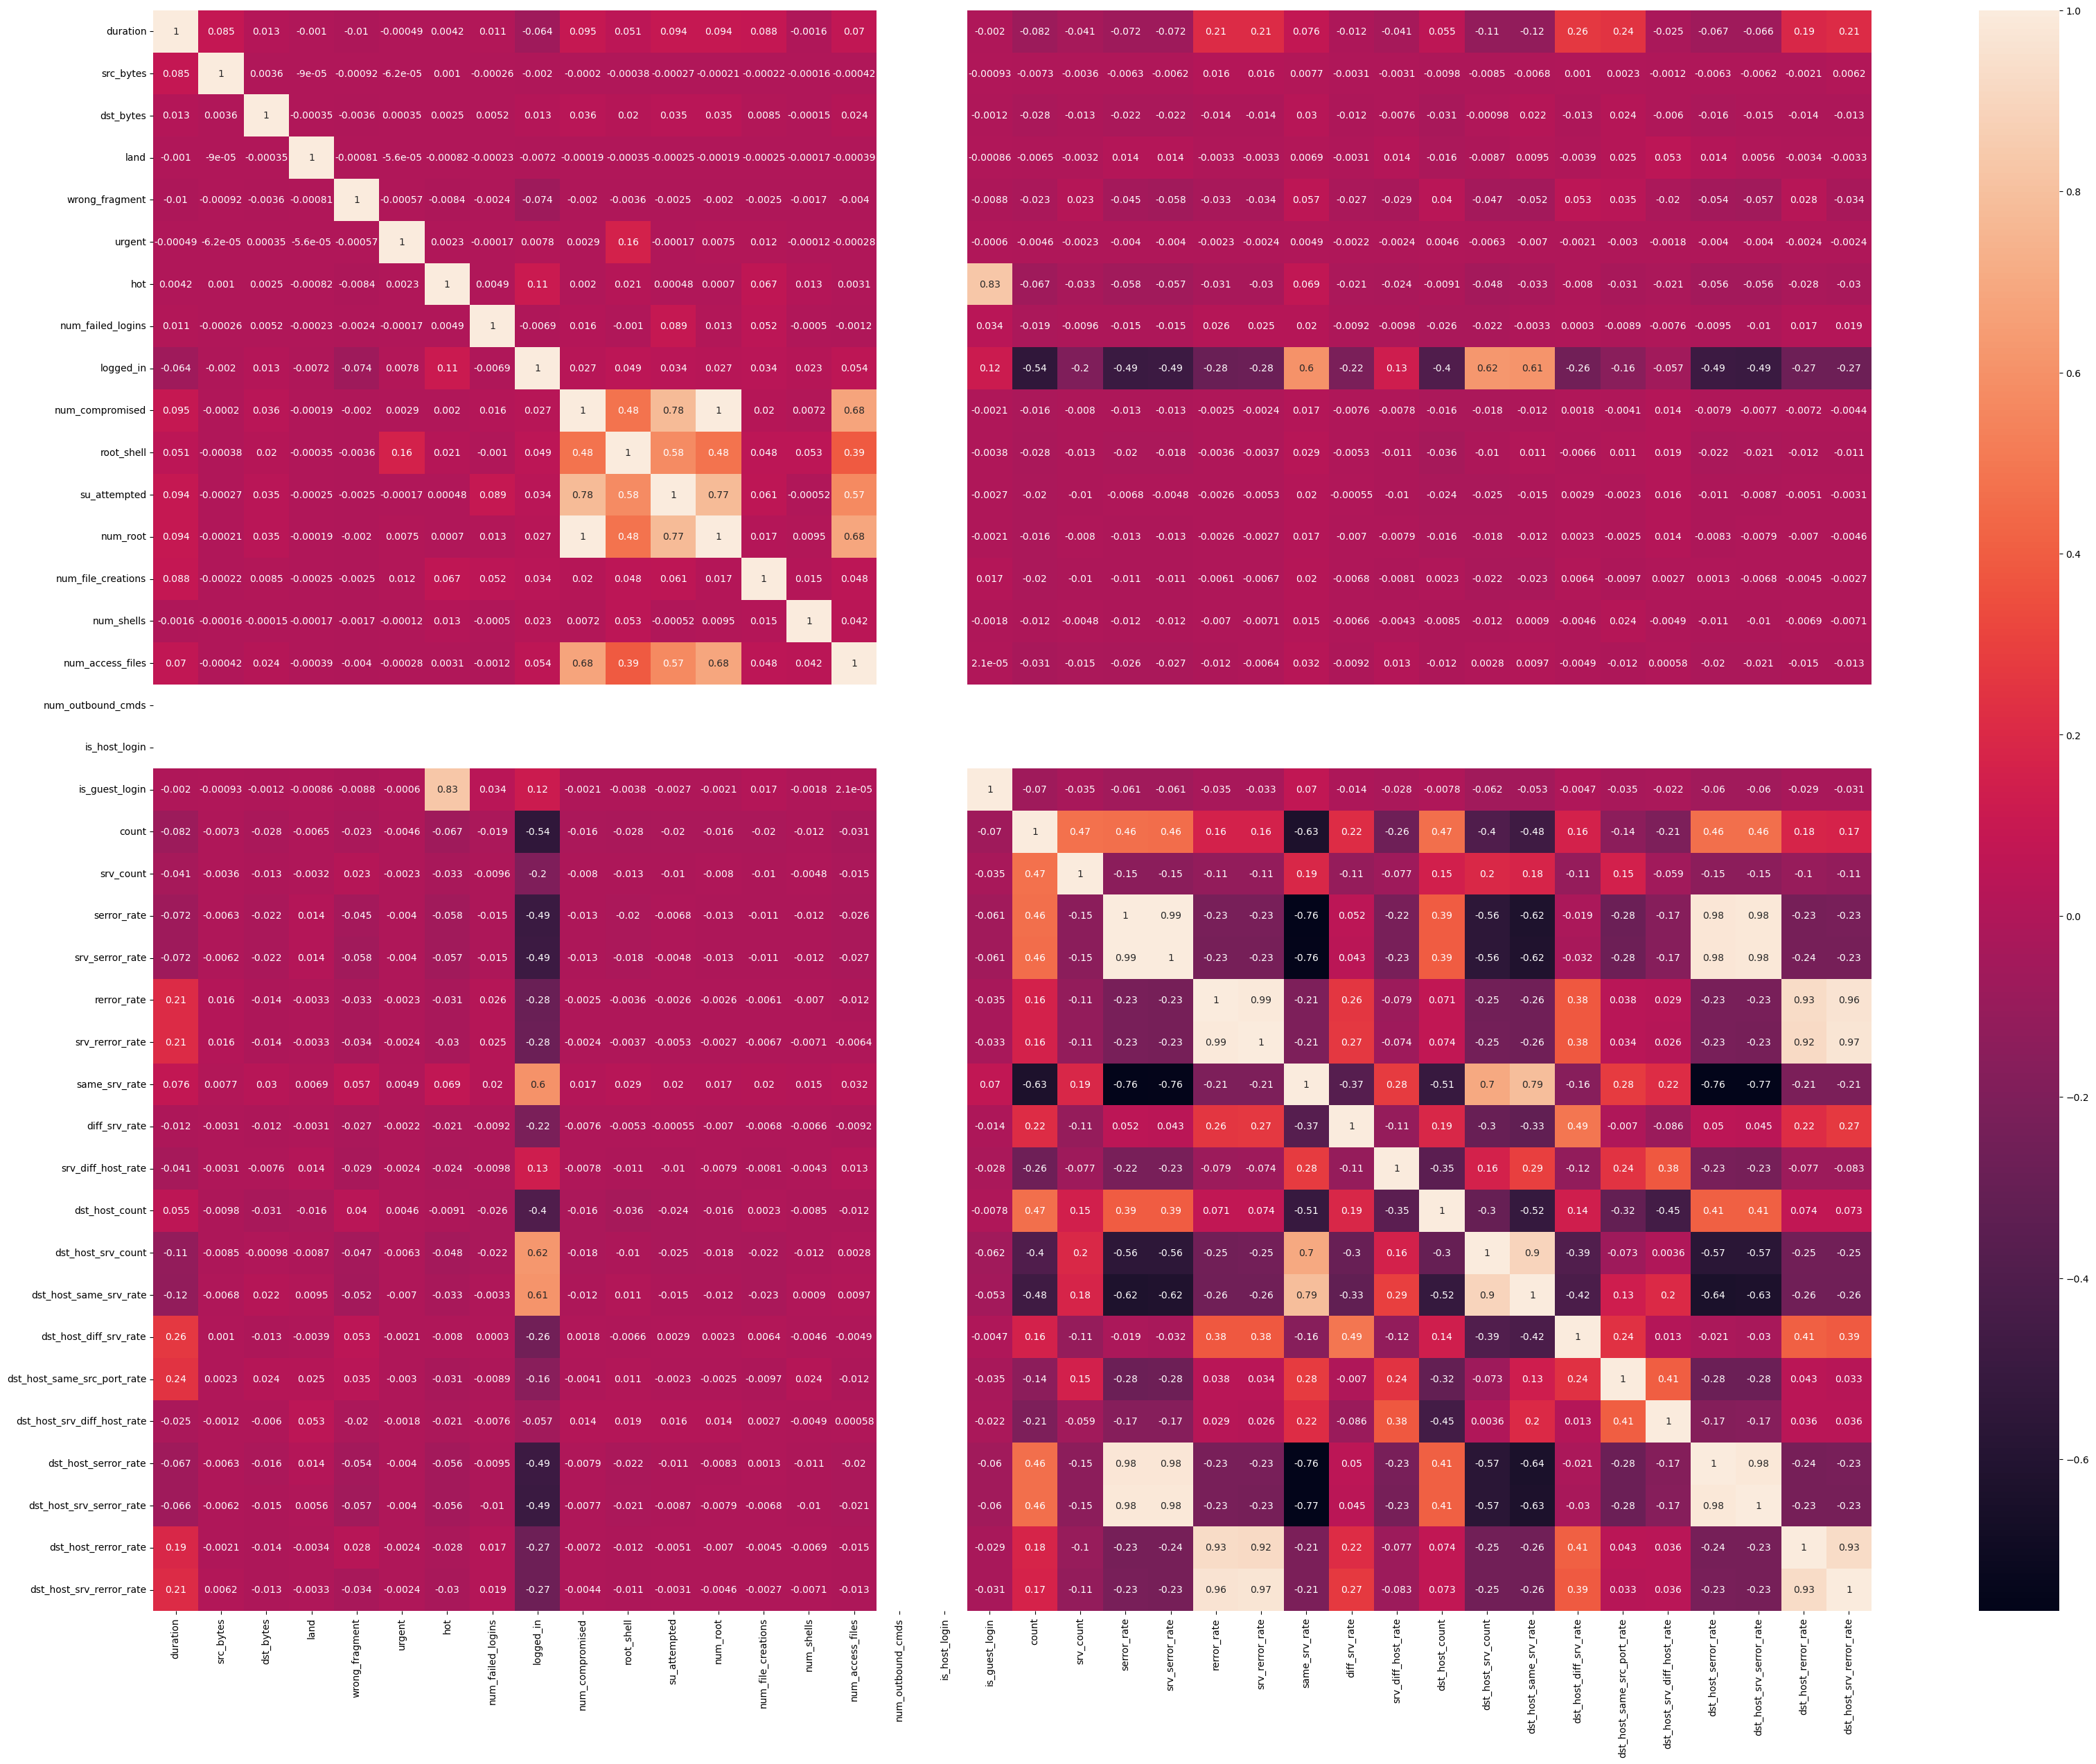

In [13]:
plt.figure(figsize=(40,30))
sns.heatmap(train.corr(numeric_only=True), annot=True)

# import plotly.express as px
# fig = px.imshow(df.corr(), text_auto=True, aspect="auto")
# fig.show()

<Axes: xlabel='class', ylabel='count'>

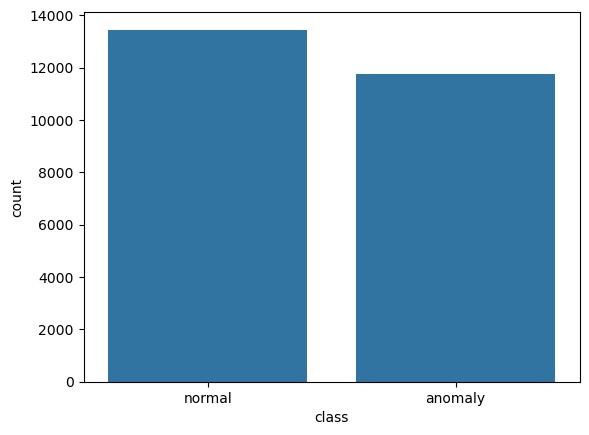

In [14]:
sns.countplot(x=train['class'])

# Label Encoding

List of Categorical columns requiring encoding and their values

In [15]:
# List of Categorical columns and their values
cat_cols = [col for col in train.columns if train[col].dtype == 'object']

for col in cat_cols:
    print(f"{col}\n{train[col].unique()}\n\n")

protocol_type
['tcp' 'udp' 'icmp']


service
['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001']


flag
['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']


class
['normal' 'anomaly']




In [16]:
def label_encode(df):
    encoders = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = {val:i for (i,val) in enumerate(df[col].unique())}
            encoders[col] = label_encoder
    
    return encoders

def get_encodings_for_column(encoding_dict: dict, col_name: str):
    return encoding_dict[col_name]

def get_encoding_labels_for_col(encoding_dict: dict, col_name: str):
    return list(encoding_dict[col_name].values())

def get_encoding_values_for_col(encoding_dict: dict, col_name: str):
    return list(encoding_dict[col_name].keys())

def get_encoding_value_for_label(encoding_dict: dict, col_name: str, label: int):
    return list(encoding_dict[col_name].keys())[label]

def get_encoding_label_for_value(encoding_dict: dict, col_name: str, value: str):
    return encoding_dict[col_name][value]

def get_reverse_encoding_dict(encoding_dict: dict):
    reverse_encoding = {
        col: {
            lbl:val for (val,lbl) in encodings_dict[col].items()
        } for col in encodings_dict
    }
    return reverse_encoding

In [17]:
encodings_dict = label_encode(train)
encodings_dict

{'protocol_type': {'tcp': 0, 'udp': 1, 'icmp': 2},
 'service': {'ftp_data': 0,
  'other': 1,
  'private': 2,
  'http': 3,
  'remote_job': 4,
  'name': 5,
  'netbios_ns': 6,
  'eco_i': 7,
  'mtp': 8,
  'telnet': 9,
  'finger': 10,
  'domain_u': 11,
  'supdup': 12,
  'uucp_path': 13,
  'Z39_50': 14,
  'smtp': 15,
  'csnet_ns': 16,
  'uucp': 17,
  'netbios_dgm': 18,
  'urp_i': 19,
  'auth': 20,
  'domain': 21,
  'ftp': 22,
  'bgp': 23,
  'ldap': 24,
  'ecr_i': 25,
  'gopher': 26,
  'vmnet': 27,
  'systat': 28,
  'http_443': 29,
  'efs': 30,
  'whois': 31,
  'imap4': 32,
  'iso_tsap': 33,
  'echo': 34,
  'klogin': 35,
  'link': 36,
  'sunrpc': 37,
  'login': 38,
  'kshell': 39,
  'sql_net': 40,
  'time': 41,
  'hostnames': 42,
  'exec': 43,
  'ntp_u': 44,
  'discard': 45,
  'nntp': 46,
  'courier': 47,
  'ctf': 48,
  'ssh': 49,
  'daytime': 50,
  'shell': 51,
  'netstat': 52,
  'pop_3': 53,
  'nnsp': 54,
  'IRC': 55,
  'pop_2': 56,
  'printer': 57,
  'tim_i': 58,
  'pm_dump': 59,
  'red_i'

In [18]:
# Before encoding
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [19]:
# Apply Encoding to train and test sets
train.replace(to_replace=encodings_dict, inplace=True)
test.replace(to_replace=encodings_dict, inplace=True)

In [20]:
# After encoding
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,0,0,0,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,1,1,0,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,0,2,1,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,0,3,0,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,0,3,0,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [21]:
# After encoding
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,2,2,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00
1,0,0,2,2,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00
2,2,0,0,0,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00
3,0,2,7,0,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00
4,1,0,9,5,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71


In [22]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,0,0,0,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,1,1,0,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,0,2,1,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,0,3,0,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,0,3,0,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [22]:
# Save the encoders_dict on disk
joblib.dump(encodings_dict, 'models/encodings_dict2.joblib')

['models/encodings_dict2.joblib']

# Feature selection

Using Feature Ranking with recursive feature Elimination (RFE approach).

In [23]:
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

In [24]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

# feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
# selected_features = [v for i, v in feature_map if i==True]
selected_features = X_train.columns[rfe.get_support()]

selected_features

Index(['service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate',
       'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_same_src_port_rate'],
      dtype='object')

In [24]:
# train['src_bytes']
selected_features = ['service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate',
       'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_same_src_port_rate']

In [25]:
X_train = X_train[selected_features]

In [26]:
X_train.head()

,service,flag,src_bytes,dst_bytes,count,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_same_src_port_rate
0,0,0,491,0,2,1.00,0.00,25,0.17,0.17
1,1,0,146,0,13,0.08,0.15,1,0.00,0.88
2,2,1,0,0,123,0.05,0.07,26,0.10,0.00
3,3,0,232,8153,5,1.00,0.00,255,1.00,0.03
4,3,0,199,420,30,1.00,0.00,255,1.00,0.00


In [27]:
X_train.min()

service                        0.0
flag                           0.0
src_bytes                      0.0
dst_bytes                      0.0
count                          1.0
same_srv_rate                  0.0
diff_srv_rate                  0.0
dst_host_srv_count             0.0
dst_host_same_srv_rate         0.0
dst_host_same_src_port_rate    0.0
dtype: float64

In [28]:
X_train.max()

service                               65.0
flag                                  10.0
src_bytes                      381709090.0
dst_bytes                        5151385.0
count                                511.0
same_srv_rate                          1.0
diff_srv_rate                          1.0
dst_host_srv_count                   255.0
dst_host_same_srv_rate                 1.0
dst_host_same_src_port_rate            1.0
dtype: float64

In [29]:
# Show unique value to confirm encoding

def show_unique_values(df):
    for col in df.columns:
        print(f"{col}:\n{df[col].unique()}\n\n")

show_unique_values(X_train)

service:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]


flag:
[ 0  1  2  3  4  5  6  7  8  9 10]


src_bytes:
[ 491  146    0 ... 1466 2499 2896]


dst_bytes:
[   0 8153  420 ... 6160   99 2257]


count:
[  2  13 123   5  30 121 166 117 270 133 205 199   3 233  96   8   1   9
 223 280 248 279  14  33  57 181 122  22 228  50 262   4  11 108  80  44
 258  10  61  26 120  73 135  24 148 206 175  63  52 125 168 145 138 276
 220 212 250 132 109 146 300 129  32  82  15  21 110   6   7 246 272 259
 294  79 190 245 263  87 292 295 143 278 102 251 222 260 511 287 486 286
  35  28 101  12  19 406  17 201 124 162 277 274 141 103 171 238 281 163
 301  16  46  39 211 256 144 104  18  74 225  66 139 241 213  36 254 179
 195  20 208 268 425  42 196 111 237 257  77 137 290 203 116 457  47  71
 200 140  68 215 115 275  76 202 252 197 198 154 204  2

In [30]:
Y_train.head()

0    0
1    0
2    1
3    0
4    0
Name: class, dtype: int64

## Scale data

In [31]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)

In [33]:
joblib.dump(scale,filename='models/scaler.joblib')

['models/scaler.joblib']

## Data Segmentation/Splitting

In [32]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

In [33]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (17634, 10)
y_train shape: (17634,)
x_test shape: (7558, 10)
y_test shape: (7558,)


In [34]:
x_train[:5]

array([[-0.63650425,  0.37067894, -0.01009252, -0.03930979,  1.70407969,
        -1.36605952, -0.12525061, -0.87725012, -0.86825665, -0.44575351],
       [-0.01506001,  0.37067894, -0.01009252, -0.03930979, -0.09236131,
        -0.88838365, -0.06924277, -0.51573243, -0.64550726, -0.47818309],
       [ 0.45102317,  1.35013603, -0.01009252, -0.03930979,  1.25060915,
        -1.32056658, -0.01323494, -0.86821217, -1.00190629, -0.47818309],
       [-0.71418478, -0.60877815, -0.01009211, -0.03930979, -0.26677306,
        -1.36605952,  0.26680423, -1.01281925, -1.13555592,  0.52713383],
       [-0.55882372, -0.60877815, -0.00997264, -0.03262278, -0.7202436 ,
         0.77210866, -0.34928194,  1.26474221,  1.06966306,  0.33255636]])

In [35]:
Y_train.head()

0    0
1    0
2    1
3    0
4    0
Name: class, dtype: int64

# K Nearest Neighbors (KNN) classification model

In [36]:
def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [37]:
study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(objective, n_trials=20)
print(study_KNN.best_trial)

FrozenTrial(number=12, state=<TrialState.COMPLETE: 1>, values=[0.9825350621857635], datetime_start=datetime.datetime(2026, 1, 28, 7, 22, 52, 578287), datetime_complete=datetime.datetime(2026, 1, 28, 7, 22, 53, 771459), params={'KNN_n_neighbors': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=12, value=None)


In [38]:
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Train Score: {KNN_train}")
print(f"Test Score: {KNN_test}")

Train Score: 0.9881478961097879
Test Score: 0.9825350621857635


In [41]:
joblib.dump(KNN_model,"models/KNN_model.joblib")

['models/KNN_model.joblib']

# Decision Tree Classifier

In [39]:
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [40]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

FrozenTrial(number=1, state=<TrialState.COMPLETE: 1>, values=[0.9955014554114845], datetime_start=datetime.datetime(2026, 1, 28, 7, 23, 6, 226574), datetime_complete=datetime.datetime(2026, 1, 28, 7, 23, 6, 284488), params={'dt_max_depth': 19, 'dt_max_features': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=1, value=None)


In [41]:
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")

Train Score: 1.0
Test Score: 0.9951045250066155


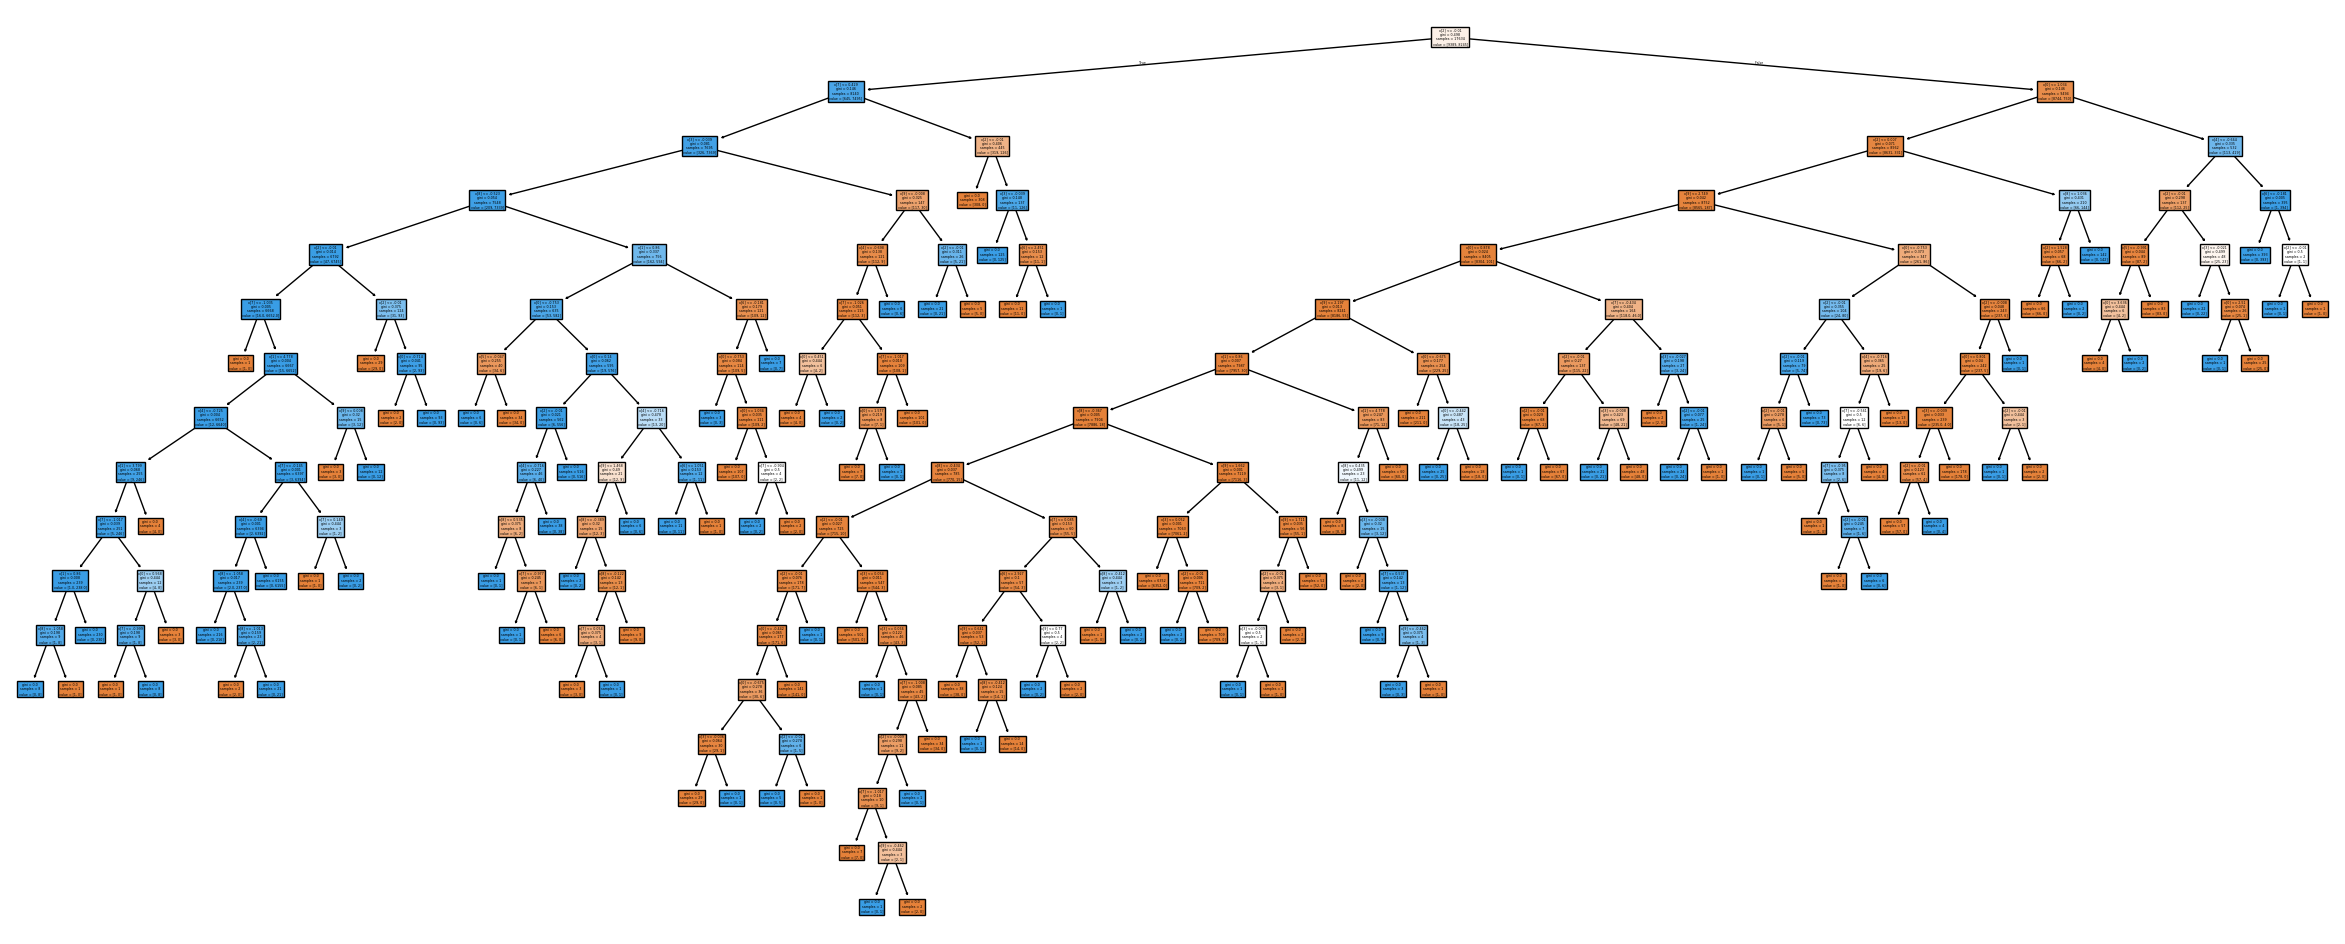

In [42]:
fig = plt.figure(figsize = (30,12))
tree.plot_tree(dt, filled=True);
plt.show()

In [43]:
dt.feature_importances_

array([0.09201059, 0.01789666, 0.76272296, 0.02866733, 0.01831041,
       0.00130337, 0.00210048, 0.04890333, 0.01894953, 0.00913534])

In [44]:
feature_importance = pd.DataFrame(
    data=dt.feature_importances_, index=selected_features, columns=["feature_importance"]
).sort_values(by="feature_importance", ascending=False)

feature_importance

,feature_importance
src_bytes,0.762723
service,0.092011
dst_host_srv_count,0.048903
dst_bytes,0.028667
dst_host_same_srv_rate,0.018950
count,0.018310
flag,0.017897
dst_host_same_src_port_rate,0.009135
diff_srv_rate,0.002100
same_srv_rate,0.001303


Text(0.5, 1.0, 'Feature Importances for Decision Tree\n')

<Figure size 1000x800 with 0 Axes>

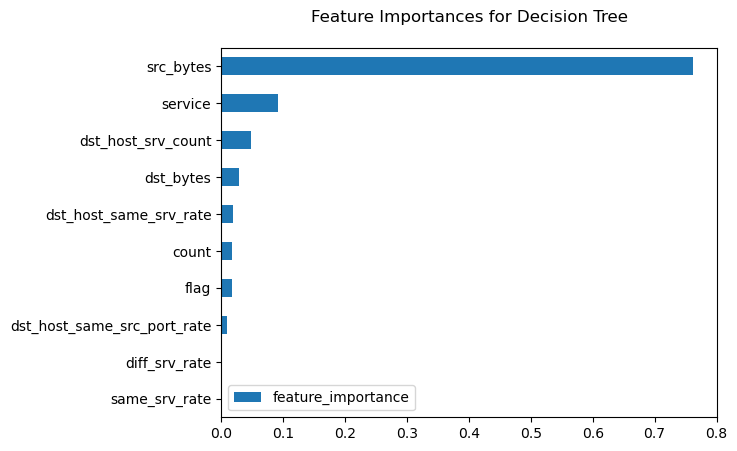

In [45]:
plt.figure(figsize=(10,8))
feature_importance.sort_values(by="feature_importance").plot.barh()
plt.title("Feature Importances for Decision Tree\n")

In [49]:
joblib.dump(dt,"models/Decision_Tree_model.joblib")

['models/Decision_Tree_model.joblib']

# Random Forest Classifier

Used Optuna for Parameter-tuning, The objective was to maximize the `accuracy` of the RandomForest Classifier model on the training set. The study/experiment was set to be done for 30-trials, the parameter set that maximizes the objective function (accuracy in our case) was then used for the final training.

The list of paramters and their value range used for the optimization are as follows:
- 'estimator': ('')
- 'rf_max_depth': (min:2, max:32)
- 'rf_max_features': (min:2, max:10)
- 'rf_n_estimators': (min:3, max:20)

In [46]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=False)
    rf_max_features = trial.suggest_int('rf_max_features', 2, 10, log=False)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 3, 20, log=False)
    classifier_obj = RandomForestClassifier(max_features = rf_max_features, max_depth = rf_max_depth, n_estimators = rf_n_estimators)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [47]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=30)
print(study_rf.best_trial)

FrozenTrial(number=0, state=<TrialState.COMPLETE: 1>, values=[0.9968245567610479], datetime_start=datetime.datetime(2026, 1, 28, 7, 23, 37, 255169), datetime_complete=datetime.datetime(2026, 1, 28, 7, 23, 37, 548070), params={'rf_max_depth': 16, 'rf_max_features': 9, 'rf_n_estimators': 9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'rf_max_features': IntDistribution(high=10, log=False, low=2, step=1), 'rf_n_estimators': IntDistribution(high=20, log=False, low=3, step=1)}, trial_id=0, value=None)


In [48]:
rf = RandomForestClassifier(max_features = study_rf.best_trial.params['rf_max_features'], max_depth = study_rf.best_trial.params['rf_max_depth'], n_estimators = study_rf.best_trial.params['rf_n_estimators'])
rf.fit(x_train, y_train)

rf_train, rf_test = rf.score(x_train, y_train), rf.score(x_test, y_test)

print(f"Train Score: {rf_train}")
print(f"Test Score: {rf_test}")

Train Score: 0.9996030395826245
Test Score: 0.9952368351415718


In [49]:
feature_importance = pd.DataFrame(
    data=rf.feature_importances_, index=selected_features, columns=["feature_importance"]
).sort_values(by="feature_importance", ascending=False)

feature_importance

,feature_importance
src_bytes,0.685072
dst_bytes,0.092008
service,0.077480
dst_host_srv_count,0.045673
count,0.040107
dst_host_same_src_port_rate,0.026531
dst_host_same_srv_rate,0.019561
flag,0.012205
same_srv_rate,0.000767
diff_srv_rate,0.000596


Text(0.5, 1.0, 'Feature Importances for Random Forest\n')

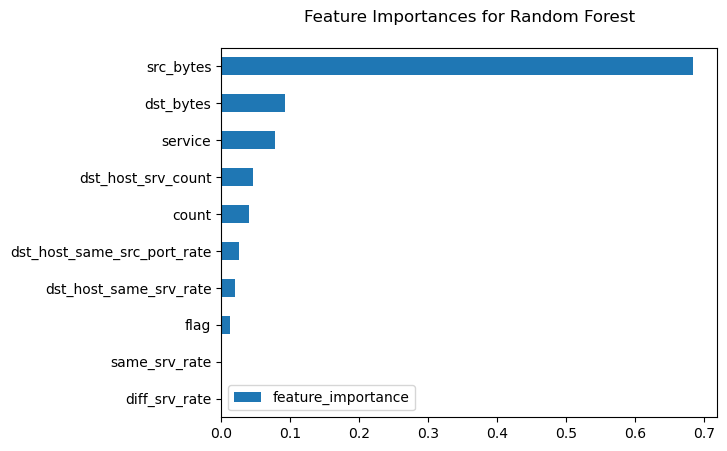

In [50]:
feature_importance.sort_values(by="feature_importance").plot.barh()
plt.title("Feature Importances for Random Forest\n")

In [55]:
joblib.dump(rf,"models/Random_Forest_model.joblib")

['models/Random_Forest_model.joblib']

# SVM Model

In [51]:
def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'linearSVC'])
    c = trial.suggest_float('c', 0.02, 1.0, step=0.02)
    if kernel in ['linear', 'rbf']:
        classifier_obj = SVC(kernel=kernel, C=c).fit(x_train, y_train)
    elif kernel == 'linearSVC':
        classifier_obj = LinearSVC(C=c).fit(x_train, y_train)
    elif kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 10)
        classifier_obj = SVC(kernel=kernel, C=c, degree=degree).fit(x_train, y_train)
        
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [52]:
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective, n_trials=30)
print(study_svm.best_trial)

FrozenTrial(number=19, state=<TrialState.COMPLETE: 1>, values=[0.9581899973537973], datetime_start=datetime.datetime(2026, 1, 28, 7, 25, 26, 278509), datetime_complete=datetime.datetime(2026, 1, 28, 7, 25, 30, 355597), params={'kernel': 'rbf', 'c': 1.0}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'rbf', 'poly', 'linearSVC')), 'c': FloatDistribution(high=1.0, log=False, low=0.02, step=0.02)}, trial_id=19, value=None)


In [53]:
if study_svm.best_trial.params['kernel'] in ['linear', 'rbf']:
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'])
elif kernel == 'linearSVC':
    SVM_model = LinearSVC(C=study_svm.best_trial.params['c'])
elif kernel == 'poly':
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'], degree=study_svm.best_trial.params['degree'])

SVM_model.fit(x_train, y_train)

SVC()

In [54]:
SVM_train, SVM_test = SVM_model.score(x_train , y_train), SVM_model.score(x_test , y_test)

print(f"Training Score: {SVM_train}")
print(f"Test Score: {SVM_test}")

Training Score: 0.9601338323692866
Test Score: 0.9581899973537973


In [60]:
joblib.dump(SVM_model,"models/SVM_model.joblib")

['models/SVM_model.joblib']

# Performance Evaluations

In [55]:
rf_predictions = rf.predict(x_test)
dt_predictions = dt.predict(x_test)
knn_predictions = KNN_model.predict(x_test)
svm_predictions = SVM_model.predict(x_test)

predictions = {
    "KNN": knn_predictions, 
    "SVM": svm_predictions, 
    "Decision Tree": dt_predictions, 
    "Random Forest": rf_predictions
}

In [56]:
models = ["Random Forest", "KNN", "SVM"]

train_accuracies = [rf_train, KNN_train, SVM_train]

test_accuracies = [rf_test, KNN_test, SVM_test]

test_precisions = [
    precision_score(y_test, rf_predictions),
    precision_score(y_test, knn_predictions),
    precision_score(y_test, svm_predictions),
]

test_recalls = [
    recall_score(y_test, rf_predictions),
    recall_score(y_test, knn_predictions),
    recall_score(y_test, svm_predictions),
]

test_f1_scores = [
    f1_score(y_test, rf_predictions),
    f1_score(y_test, knn_predictions),
    f1_score(y_test, svm_predictions),
]

results_data = {
    "Model": models,
#     "Train Accuracy": train_accuracies,
    "Accuracy": test_accuracies,
    "Precision": test_precisions,
    "Recall": test_recalls,
    "F1-Score": test_f1_scores
}

results_df = pd.DataFrame(results_data)

results_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.995237,0.994854,0.994854,0.994854
1,KNN,0.982535,0.983065,0.979131,0.981094
2,SVM,0.958190,0.958501,0.950829,0.954650


# Summary

In [57]:
data = [
    ["Random Forest", rf_train, rf_test], 
    ["Decision Tree", dt_train, dt_test], 
    ["KNN", KNN_train, KNN_test], 
    ["SVM", SVM_train, SVM_test]
]

col_names = ["Model", "Train Score", "Test Score",]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════╤═══════════════╤══════════════╕
│ Model         │   Train Score │   Test Score │
╞═══════════════╪═══════════════╪══════════════╡
│ Random Forest │      0.999603 │     0.995237 │
├───────────────┼───────────────┼──────────────┤
│ Decision Tree │      1        │     0.995105 │
├───────────────┼───────────────┼──────────────┤
│ KNN           │      0.988148 │     0.982535 │
├───────────────┼───────────────┼──────────────┤
│ SVM           │      0.960134 │     0.95819  │
╘═══════════════╧═══════════════╧══════════════╛


In [58]:
print(tabulate(results_df.values, headers=results_df.columns, tablefmt="fancy_grid"))

╒═══════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Model         │   Accuracy │   Precision │   Recall │   F1-Score │
╞═══════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Random Forest │   0.995237 │    0.994854 │ 0.994854 │   0.994854 │
├───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ KNN           │   0.982535 │    0.983065 │ 0.979131 │   0.981094 │
├───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ SVM           │   0.95819  │    0.958501 │ 0.950829 │   0.95465  │
╘═══════════════╧════════════╧═════════════╧══════════╧════════════╛


# Classification Reports

In [59]:
# Save results
train_test_results_df = pd.DataFrame(data, columns=col_names)
train_test_results_df.to_csv("results/train_test_results_df.csv")
results_df.to_csv("results/results_all_metrics.csv")

In [60]:
for model, prediction in predictions.items():
    title = f"{model} Classification Reports"
    print(f"\n\t\t{title}\n\t\t{"-" * (len(title))}\n")
    print(classification_report(y_test, knn_predictions))


		KNN Classification Reports
		--------------------------

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4060
           1       0.98      0.98      0.98      3498

    accuracy                           0.98      7558
   macro avg       0.98      0.98      0.98      7558
weighted avg       0.98      0.98      0.98      7558


		SVM Classification Reports
		--------------------------

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4060
           1       0.98      0.98      0.98      3498

    accuracy                           0.98      7558
   macro avg       0.98      0.98      0.98      7558
weighted avg       0.98      0.98      0.98      7558


		Decision Tree Classification Reports
		------------------------------------

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4060
           1       0.98      0.98    

# Confusion Matrix

In [61]:
labels = ["normal", "anomaly"]

Text(0.5, 1.0, '\nKNN Confusion Matrix\n')

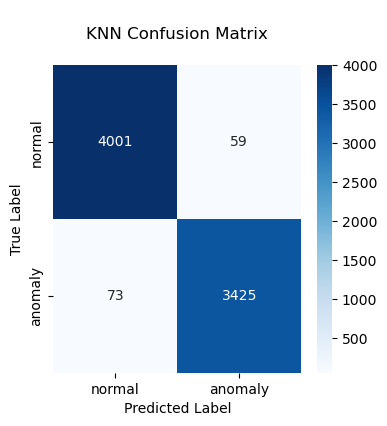

In [62]:
# Confusion Matrix
plt.figure(figsize=(4,4))

title = f"KNN Confusion Matrix"
cf = confusion_matrix(y_test, predictions["KNN"])
sns.heatmap(
    cf, fmt="g", annot=True, cmap="Blues", 
    xticklabels=labels, yticklabels=labels
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"\n{title}\n")


Text(0.5, 1.0, '\nSVM Confusion Matrix\n')

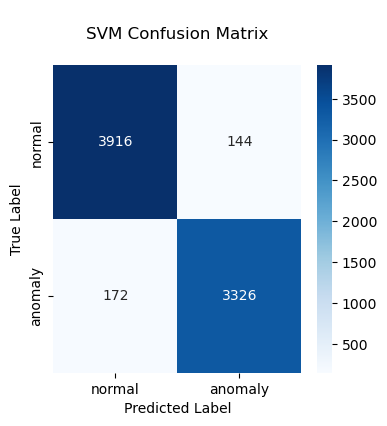

In [63]:
# Confusion Matrix
plt.figure(figsize=(4,4))

title = f"SVM Confusion Matrix"
cf = confusion_matrix(y_test, predictions["SVM"])
sns.heatmap(
    cf, fmt="g", annot=True, cmap="Blues", 
    xticklabels=labels, yticklabels=labels
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"\n{title}\n")

Text(0.5, 1.0, '\nDecision Tree Confusion Matrix\n')

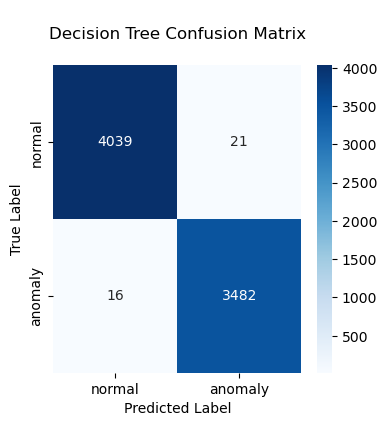

In [64]:
# Confusion Matrix
plt.figure(figsize=(4,4))

title = f"Decision Tree Confusion Matrix"
cf = confusion_matrix(y_test, predictions["Decision Tree"])
sns.heatmap(
    cf, fmt="g", annot=True, cmap="Blues", 
    xticklabels=labels, yticklabels=labels
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"\n{title}\n")

Text(0.5, 1.0, '\nRandom Forest Confusion Matrix\n')

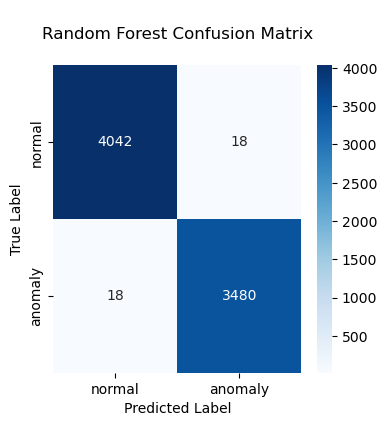

In [65]:
# Confusion Matrix
plt.figure(figsize=(4,4))

title = f"Random Forest Confusion Matrix"
cf = confusion_matrix(y_test, predictions["Random Forest"])
sns.heatmap(
    cf, fmt="g", annot=True, cmap="Blues", 
    xticklabels=labels, yticklabels=labels
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"\n{title}\n")

In [66]:
# Save results
train_test_results_df = pd.DataFrame(data, columns=col_names)
train_test_results_df.to_csv("results/train_test_results_df.csv")
results_df.to_csv("results/results_all_metrics.csv")

# Inference Testing

In [66]:
# Loading and using a trained model for sample inference
model = joblib.load("models/Decision_Tree_model.joblib")
model.predict(x_test)

array([1, 1, 1, ..., 0, 0, 0])

In [67]:
# Library Versions Used

import sklearn as skl
import tabulate as tbl
import matplotlib as mplot

print(f"Sk-Learn: {skl.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Joblib: {joblib.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"Tabulate: {tbl.__version__}")
print(f"Optuna: {optuna.__version__}")
print(f"Matplotlib: {mplot.__version__}")


Sk-Learn: 1.6.1
Numpy: 2.1.3
Pandas: 2.2.3
Joblib: 1.4.2
Seaborn: 0.13.2
Tabulate: 0.9.0
Optuna: 4.7.0
Matplotlib: 3.10.0


# Test Samples Data

In [75]:
# Normal

t = train[train['class'] == 0]
selected = ['service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate',
       'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_same_src_port_rate','class']
t[selected].head()

,service,flag,src_bytes,dst_bytes,count,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_same_src_port_rate,class
0,0,0,491,0,2,1.00,0.00,25,0.17,0.17,0
1,1,0,146,0,13,0.08,0.15,1,0.00,0.88,0
3,3,0,232,8153,5,1.00,0.00,255,1.00,0.03,0
4,3,0,199,420,30,1.00,0.00,255,1.00,0.00,0
12,3,0,287,2251,3,1.00,0.00,219,1.00,0.12,0


In [74]:
# Anomalies

t = train[train['class'] == 1]
selected = ['service', 'flag', 'src_bytes', 'dst_bytes', 'count', 'same_srv_rate',
       'diff_srv_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_same_src_port_rate','class']
t[selected].head()

,service,flag,src_bytes,dst_bytes,count,same_srv_rate,diff_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_same_src_port_rate,class
2,2,1,0,0,123,0.05,0.07,26,0.10,0.0,1
5,2,2,0,0,121,0.16,0.06,19,0.07,0.0,1
6,2,1,0,0,166,0.05,0.06,9,0.04,0.0,1
7,2,1,0,0,117,0.14,0.06,15,0.06,0.0,1
8,4,1,0,0,270,0.09,0.05,23,0.09,0.0,1
